# Importing libraries

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Random Actions on env

In [4]:
env = gym.make('CartPole-v0')
env.reset()
for i in range(10):
    env.step(0)
    env.render()

/home/tanmayp/Desktop/RL/Minigrid/rl_env/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Creating linear layer network for Function approximation

In [2]:
class DQN(nn.Module):
    def __init__(self, input_dims, lr):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dims, out_features=32)  #
        self.fc2 = nn.Linear(in_features=32, out_features=2)
        #self.fc3 = nn.Linear(in_features=128, out_features=2)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        
    def forward(self, t):
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        #t = F.relu(t)
        #t = self.fc3(t)
        return t

## Creating Agent class for action selection

In [3]:
class Agent():
    def __init__(self, gamma, eps, eps_min, eps_decay, num_actions, device):
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, rate, state, policy_net):
        if random.random() > rate:
            obs = torch.tensor([state], dtype=torch.float32).to(self.device)
            return policy_net(obs).argmax(dim=1).item()
        else:
            return np.random.choice(self.num_actions)

## Creating Replay Memory class for storing data and providing dataset

In [4]:
class ReplayMemory():
    def __init__(self, capacity, batch_size, input_dims, eps, eps_min, eps_decay):
        self.capacity = capacity
        self.batch_size = batch_size
        self.state_memory  = np.zeros((capacity, input_dims), dtype=np.float32)
        self.action_memory = np.zeros(capacity, dtype=np.int32)
        self.reward_memory = np.zeros(capacity, dtype=np.float32)
        self.next_state_memory = np.zeros((capacity, input_dims), dtype=np.float32)
        self.terminal_memory = np.zeros(capacity, dtype=np.bool)
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.experience_ctr = 0
        
    def store(self, state, action, reward, next_state, terminal):
        index = self.experience_ctr % self.capacity
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = terminal
        self.experience_ctr += 1
        
    def can_provide_batch(self):
        return self.experience_ctr >= batch_size
    
    def give_batch(self):
        length = min(self.experience_ctr, self.capacity)
        batch = np.random.choice(length, self.batch_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]
        return (states, actions, rewards, next_states, terminals)
    
    def get_epsilon(self):
        #print(self.experience_ctr)
        rate = self.eps_min + (self.eps - self.eps_min) * math.exp(-1. * self.experience_ctr / self.eps_decay)
        return rate

## Parameters

In [5]:
batch_size = 64
gamma = 0.999
eps = 0.9
eps_min = 0.05
eps_decay = 500
update_rate = 10
capacity = 100000
lr = 0.001
input_dims = 4
num_episodes = 200

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining policy and Target Nets

In [7]:
policy_net = DQN(input_dims, lr).to(device)
target_net = DQN(input_dims, lr).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (loss): MSELoss()
)

In [8]:
pytorch_total_params = sum(p.numel() for p in policy_net.parameters())
print(f"total parameters = {pytorch_total_params}")

total parameters = 226


## Making environment, agent and memory

In [9]:
agent = Agent(gamma, eps, eps_min, eps_decay, 2, device)
memory = ReplayMemory(capacity, batch_size, 4, eps, eps_min, eps_decay)

In [10]:
env = gym.make('CartPole-v0')

In [11]:
def get_tensors(batch, device):
    states = torch.tensor(batch[0]).to(device)
    actions = batch[1]
    rewards = torch.tensor(batch[2]).to(device)
    next_states = torch.tensor(batch[3]).to(device)
    dones = torch.tensor(batch[4]).to(device)
    return states, actions, rewards, next_states, dones

## Training of Network

In [12]:
score_track = []
eps_track = []
loss_track = []
batch_index = np.arange(batch_size, dtype = np.int32)
for episode in range(num_episodes):
    print('Episode : ', episode, end='\t')
    score = 0
    terminal = False
    state = env.reset()
    while not terminal:
        rate = memory.get_epsilon()
        #print(rate)
        eps_track.append(rate)
        action = agent.select_action(rate, state, policy_net)
        next_state, reward, terminal, emp = env.step(action)
        memory.store(state, action, reward, next_state, terminal)
        state = next_state
        score += reward
        
        if memory.can_provide_batch():
            batch = memory.give_batch()
            states, actions, rewards, next_states, dones = get_tensors(batch, device)
            
            current_q_values = policy_net.forward(states)[batch_index, actions]
            current_q_values = current_q_values.reshape(-1,1)
            next_q_values = target_net.forward(next_states)
            next_q_values[dones] = 0.0
            next_q_values = torch.max(next_q_values, dim=1)[0].detach()
            
            target_q_values = (gamma * next_q_values) + rewards
            target_q_values = target_q_values.reshape(-1,1)
            #print(current_q_values.shape, next_q_values.shape, rewards.shape)
            policy_net.optimizer.zero_grad()
            loss = policy_net.loss(target_q_values, current_q_values)
            loss_track.append(loss.item())
            loss.backward()
            policy_net.optimizer.step()
            
    score_track.append(score)
    print('Score : ', score)
    if episode%update_rate==0:
        target_net.load_state_dict(policy_net.state_dict())

Episode :  0	Score :  21.0
Episode :  1	Score :  20.0
Episode :  2	Score :  14.0
Episode :  3	Score :  14.0
Episode :  4	Score :  10.0
Episode :  5	Score :  15.0
Episode :  6	Score :  23.0
Episode :  7	Score :  9.0
Episode :  8	Score :  20.0
Episode :  9	Score :  18.0
Episode :  10	Score :  14.0
Episode :  11	Score :  11.0
Episode :  12	Score :  28.0
Episode :  13	Score :  12.0
Episode :  14	Score :  16.0
Episode :  15	Score :  14.0
Episode :  16	Score :  23.0
Episode :  17	Score :  10.0
Episode :  18	Score :  20.0
Episode :  19	Score :  18.0
Episode :  20	Score :  9.0
Episode :  21	Score :  12.0
Episode :  22	Score :  11.0
Episode :  23	Score :  14.0
Episode :  24	Score :  10.0
Episode :  25	Score :  11.0
Episode :  26	Score :  10.0
Episode :  27	Score :  16.0
Episode :  28	Score :  13.0
Episode :  29	Score :  17.0
Episode :  30	Score :  13.0
Episode :  31	Score :  9.0
Episode :  32	Score :  10.0
Episode :  33	Score :  13.0
Episode :  34	Score :  18.0
Episode :  35	Score :  9.0
Episod

## Plotting scores, epsilon, loss vs episodes

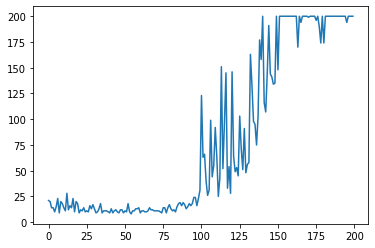

In [13]:
x = range(len(score_track))
plt.plot(x, score_track)

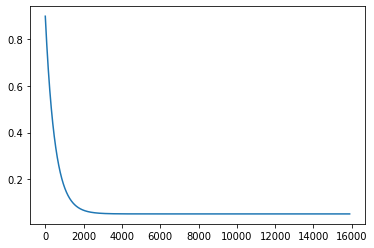

In [14]:
x = range(len(eps_track))
plt.plot(x, eps_track)

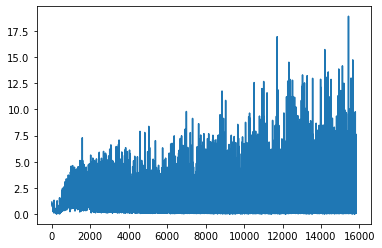

In [15]:
x = range(len(loss_track))
plt.plot(x, loss_track)

## Evaluating network

In [16]:
state = env.reset()
score = 0
games = 100
done = False
avg_score = []
avg_score_track = []
for i in range(games):
    score = 0
    state = env.reset()
    done = False
    while not done:
        obs = torch.tensor(env.state, dtype=torch.float32).to(device)
        action = torch.argmax(policy_net(obs)).item()
        #action = agent.select_action(state, policy_net)
        next_state, reward, done, _ = env.step(action)
        score += reward
    
    avg_score.append(score)
print(np.mean(avg_score))    
#a = torch.tensor([[1,2,3,4], [1,1,1,1]], dtype=torch.float32).to(device)
#b = policy_net(a)
#print(b, b.shape)

199.91
